In [119]:
from sklearn.cluster import FeatureAgglomeration
import numpy as np
import pandas as pd
import multiprocessing
import matplotlib.pyplot as plt
import seaborn as sns

In [120]:
def open_df():
    
    rgb_df = pd.read_csv('/home/emmanuelgonzalez/work/season10_rgb_flir_detections/season10_rgb/2020-03-03_detection.csv').query('plot == "MAC_Field_Scanner_Season_10_Range_10_Column_17"')
    flir_df = pd.read_csv('/home/emmanuelgonzalez/work/season10_rgb_flir_detections/season10_flir/2020-03-03_indv_temps.csv').query('plot == "MAC_Field_Scanner_Season_10_Range_10_Column_17"')
    return rgb_df, flir_df


def find_shared_plots(rgb_df, flir_df):
    
    rgb_df, flir_df = open_df()
    rgb_plots = rgb_df['plot'].unique()
    flir_plots = flir_df['plot'].unique()
    
    return list(set(rgb_plots) & set(flir_plots))


def cluster_plot(plot):
    
    rgb_df, flir_df = open_df()
    rgb_df = rgb_df.query(f'plot == "{plot}"')
    flir_df = flir_df.query(f'plot == "{plot}"')
    genotype = flir_df['genotype']

    rgb_lat_lon = rgb_df[["lat", "lon", "bounding_area_m2"]]
    flir_lat_lon = flir_df[["lat", "lon", "bounding_area_m2"]]

    df = pd.concat([rgb_lat_lon, flir_lat_lon])
    #arr = np.array([df['lat'], df['lon']])
    arr = np.array([df['lat'], df['lon']])
    
    max_clusters = np.max([len(rgb_lat_lon), len(flir_lat_lon)])

    agglo = FeatureAgglomeration(n_clusters=max_clusters, linkage='single', affinity='cosine')
    res = agglo.fit(arr)

    labels = res.labels_
    plot = np.array(genotype)
    #print(np.jo(labels, plot))
    df['labels'] = labels
    df['genotype'] = genotype
    
    return df

In [121]:
rgb_df, flir_df = open_df()
plot_list = find_shared_plots(rgb_df, flir_df)[0:1]

major_df = pd.DataFrame()

with multiprocessing.Pool(multiprocessing.cpu_count()-1) as p:
    df = p.map(cluster_plot, plot_list)
    major_df = major_df.append(df)
    #cluster_plot(rgb_df, flir_df, plot)

In [122]:
major_df

,lat,lon,bounding_area_m2,labels,genotype
15050,33.074870,-111.974964,0.060086,5,NaN
15051,33.074861,-111.974964,0.055563,1,NaN
15052,33.074853,-111.974964,0.069713,2,NaN
15053,33.074857,-111.974964,0.064194,6,NaN
15054,33.074880,-111.974964,0.045016,8,NaN
15055,33.074851,-111.974965,0.047406,4,NaN
15056,33.074865,-111.974964,0.061321,3,NaN
15057,33.074875,-111.974964,0.053887,0,NaN
15058,33.074878,-111.974964,0.051224,8,NaN
9781,33.074868,-111.974963,0.044354,5,GRxI_1094


<AxesSubplot:xlabel='lat', ylabel='lon'>

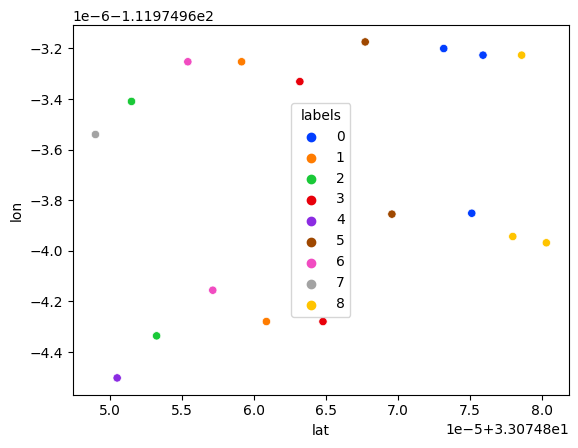

In [123]:
k = major_df["labels"].nunique()
fig, ax = plt.subplots()
sns.scatterplot(x="lat", y="lon", data=major_df, 
                palette=sns.color_palette("bright",k),
                hue='labels', legend="brief", ax=ax)
# ax.scatter(th_centroids[:,0], th_centroids[:,1], s=50, c='black', 
#            marker="x")

In [30]:
major_df.to_csv('/mnt/c/Users/emman/OneDrive - University of Arizona/agg_flir_rgb_single_cosine.csv')